# 2. Conversion Probabilities (Bayesian Approach)

Here we are going to use our Keanu widget experiment to perform Bayesian conversion probability estimation. Now although we may reach similar conclusions to our previously used frequenist methods, the way we can translate this information is different (and in some cases, preferable). Notably, trying to explain confidence intervals and p-values to non-technical personnel can be tricky and the p-value is often (wrongly) interpreted as the probability that the experimental condition “out-performed” the control. Luckily Bayesian counter-parts to this form of significance testing provide us with this information, which is incredibly useful in a commercial setting, as this is just the information stakeholders want to know.

Where frequentist measures give us a p-value and confidence intervals, Bayesian methods give us a number of posterior distributions, including: the distributions for each group mean and both absolute and relative differences between groups. Moreover, we can also get an output that shows us the probability that the variant beat the control condition. Which can be a really intuitive way to present findings to stakeholders.

These calculations use the [pymc3 package](https://www.google.com/search?q=pymc3&oq=pymc3&aqs=chrome.0.0l5j69i61j69i60l2.1004j0j1&sourceid=chrome&ie=UTF-8) in Python, which is a powerful library that can be used for computing [Markov Chain Monte-Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) simulations. These simulations are used to calculate a (pre-specified) volume of credible samples in relation to our actual conversion probabilities in order to create posterior distributions for a variety of parameters. Due to the typically large sample-sizes and random bucketing that is associated with A/B testing, we can hold a fair amount of confidence in our posterior data for both our experimental groups. We also use minimilarly minimally informative normal priors; that is they do not yield significant impact on our posterior distributions.

Now, let's dig back into our Keanu widget example.

Your first going to want to import all the relevant packages for analysis:

In [1]:
%matplotlib inline
from scipy.stats import beta
import pymc3 as pm
import seaborn as sb
from theano import config
config.warn.round=False
import warnings
from numba import jit
import numpy as np
from math import lgamma

In [2]:
import warnings
warnings.filterwarnings("ignore")

You're now going to want to insert the number of unique browsers/users that were in each bucket of your experiment:

In [3]:
n_control = 164246

n_variant = 174904

Now, input the number of unique events fired in each bucket. Using the example given above, this will be the number of unique clicks on your old and new widget/element:

In [4]:
e_control = 7883

e_variant = 10348

Create calc_prob_between function - taken from [Calc_prob - repo](https://gist.github.com/vlavorini/41d5440d107cc19453c862458804787c). This function will be used later to determine the probability the variant beat the control condition in our experiment:

In [5]:
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

The below code sets our priors for both control and variant, respectively. Using the calc_prob_between function we have created above, we can now compute the observed uplift between experimental conditions and the probability that the variant out performed the control. Here we have used a beta distribution for our priors. In Bayesian inference, the beta distribution is the conjugate prior probability distribution for the Bernoulli distribution, which is entirely applicable to the calculation of conversion probabilities:

In [6]:
## Control ##

a_control = e_control + 1
b_control = n_control - (e_control + 1)
beta_control = beta(a_control, b_control)

## Variant ##

a_variant = e_variant + 1
b_variant = n_variant - (e_variant + 1)
beta_variant = beta(a_variant, b_variant)

## Calcuate the uplift

uplift = (beta_variant.mean() - beta_control.mean())/beta_control.mean()
print("The relative uplift/decrease between the Variant (Keanu - B & T) and Control (The Matrix) group is:",round(uplift*100,4),"%")

## Calculate the probability for test to be better than the control

prob = calc_prob_between(beta_variant, beta_control)
print("The probability that the Variant (Keanu - B & T) beat the Control (The Matrix) is:",round(prob*100,3),"%")

The relative uplift/decrease between the Variant (Keanu - B & T) and Control (The Matrix) group is: 23.267 %


The probability that the Variant (Keanu - B & T) beat the Control (The Matrix) is: 100.0 %


![](keanu_uplift.png)


We are now ready to fit our observed data to the model and calculate/plot our posterior distributions. As we are calculating conversion probabilities, we'll again use a beta distribution for the priors and now a Bernoulli distribution for the likelihood parameters. We can also specify in the pm.Deterministic call that we want to calculate the posterior distribution for both absolute and relative differences between groups. 

To finalise our model parameters we need to specify the volume of draws, the sampling method step and the initial state for MCMC to instantiate:

In [7]:
with pm.Model() as model:
    
    # Define priors (use the control pirior as the null hypothesis where no difference exists between variants)
    
    prior_control_matrix = pm.Beta('prior_control', alpha = e_control, beta = n_control - e_control)
    prior_variant_bill_and_ted = pm.Beta('prior_variant', alpha = e_variant, beta = n_variant - e_variant)

    # Define likelihood
    
    likelihood_control = pm.Binomial('like_control', n = 164246, p = prior_control_matrix, observed = e_control)
    likelihood_variant = pm.Binomial('like_variant', n = 174904, p = prior_variant_bill_and_ted, observed = e_variant)
    
    # Define metrics
    
    pm.Deterministic('absolute difference', prior_variant_bill_and_ted - prior_control_matrix)
    pm.Deterministic('relative difference', (prior_variant_bill_and_ted / prior_control_matrix) - 1)

    # Inference using MCMC
    trace = pm.sample(draws = 20000, step = pm.Metropolis(), start = pm.find_MAP(), progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>Metropolis: [prior_variant]


>Metropolis: [prior_control]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 20 seconds.


The number of effective samples is smaller than 10% for some parameters.


We can now plot all of our posterior distributions. We skip the first 1000 samples as they can be noisy. On the left column you see the posterior distributions for control, variant and both absolute and relative differences. On the right column you see the sampling value for each step of the 20,000 credible samples:

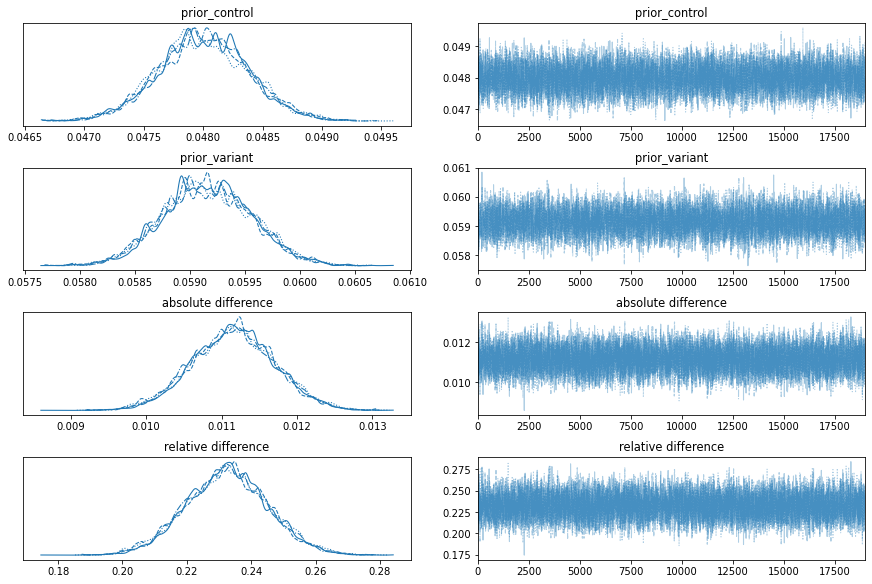

In [32]:
_ = pm.traceplot(trace[1000:])

We can also call out individual posterior distributions for from our model. Below is the distribution for both control and variant groups. As you can see no values fall outside our highest density interval (HDI), which encompasses the points with the greatest probability density (that is the samples that are more likely than that outside the parameters passed). This means we can be extremely positive that these distributions represent where the true mean values for each group exist:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcff7528fd0>,
      dtype=object)

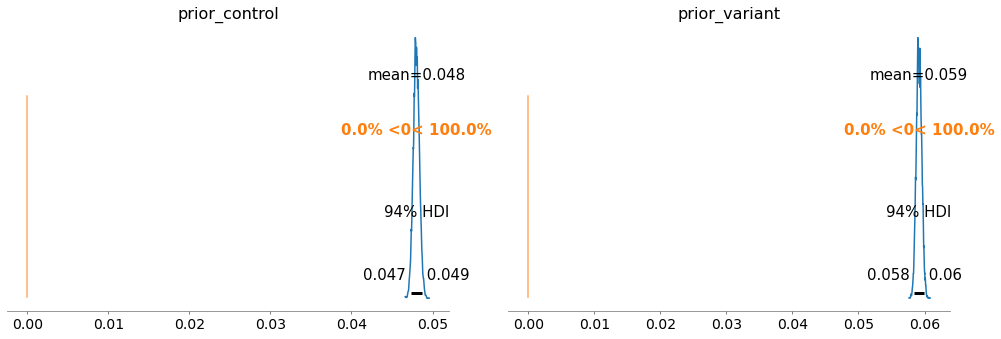

In [33]:
pm.plot_posterior(trace, var_names=['prior_control', 'prior_variant'], 
                      ref_val=0)

Similarly, we can plot the posterior distributions for both absolute and relative differences between the control and variant. As you can see the HDI for the absolute difference covers values between 1 and 1.2% and the relative HDI covers values between 21 and 23%, respectively; with no draws being below 100%:

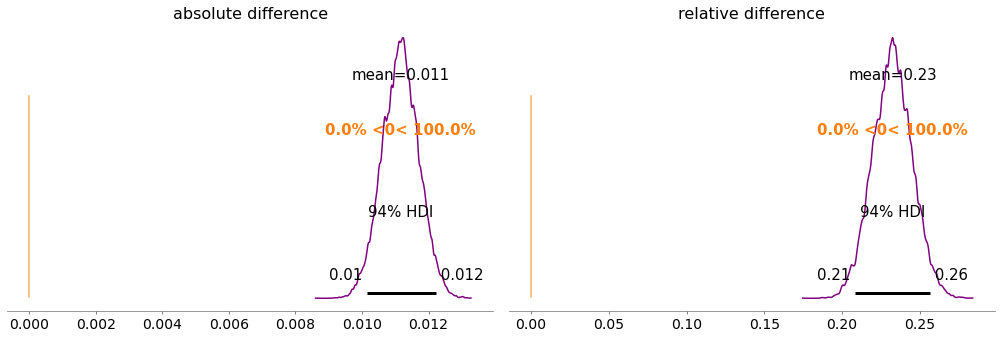

In [34]:
_ = pm.plot_posterior(trace[1000:], varnames=['absolute difference', 'relative difference'], 
                      ref_val=0, color='purple')

In the next chapter we move on to continuous (non-discrete variables), starting with frequentist methods.